In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import rdkit
from rdkit import Chem

# shut off warnings
from rdkit import RDLogger                                                                                                                                                               
RDLogger.DisableLog('rdApp.*')  

# Helper functions

In [2]:
def convert_df_smis_to_fps(df, smi_column = 'SMILES'):
    smiles = list(df[smi_column])
    mols = [Chem.MolFromSmiles(x) for x in smiles if type(x) is not float]
    fps = [Chem.RDKFingerprint(x) for x in mols if x is not None]
    return(fps)

def make_joined_list_of_fps_and_labels(list_of_lists, labels_in_order):
    fp_list = []
    lab_list = []
    for lab, currlist in zip(labels_in_order, list_of_lists):
        fp_list.extend(currlist) # could be slow for long lists or many long lists
        lab_list.extend([lab] * len(currlist))
    return(fp_list, lab_list)

def tsne_from_pca_components(fp_list, fp_labels, fig_path, colors = None):
    # use all PCs
    pca = PCA(n_components=np.min([len(fp_list), len(fp_list[0])]))
    crds = pca.fit_transform(fp_list)

    # use PCs as input to tSNE
    crds_embedded = TSNE(n_components=2).fit_transform(crds)

    tsne_df = pd.DataFrame(crds_embedded,columns=["X","Y"])
    tsne_df['label'] = fp_labels
              
    plt.figure(figsize=(5,5), dpi = 300)
    if colors == None:
        palette = sns.color_palette("hls", len(set(fp_labels)))
    else:
        ordered_labs = tsne_df.drop_duplicates('label')
        palette = dict(zip(list(ordered_labs['label']), colors))
    ax = sns.scatterplot(data=tsne_df,x="X",y="Y",hue="label", palette = palette, alpha = 0.7, s = 7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig(fig_path + '.png')
    plt.savefig(fig_path + '.svg')  
    plt.show()

# Plot 37K, abx, PK-1760 t-SNE

In [3]:
data_path = '../data/'

full37kpk = pd.read_csv(data_path + 'data_prep_for_ml_pk_37k_screen/FULL_03_19_2022.csv')
print('num 37K + PK: ', len(full37kpk))

pkonly = pd.read_csv(data_path + 'data_prep_for_ml_pk_screen/FULL_11_15_2021.csv')
print('num PK only: ', len(pkonly))

full37konly = full37kpk[[smi not in list(pkonly['SMILES']) for smi in list(full37kpk['SMILES'])]]
print('num 37K only: ', len(full37konly))

abx = pd.read_csv(data_path + '04052022_CLEANED_v5_antibiotics_across_many_classes.csv')
print('num abx: ', len(abx))

num 37K + PK:  38680
num PK only:  1759
num 37K only:  36897
num abx:  566


/Users/jackie16201/opt/anaconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/jackie16201/opt/anaconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


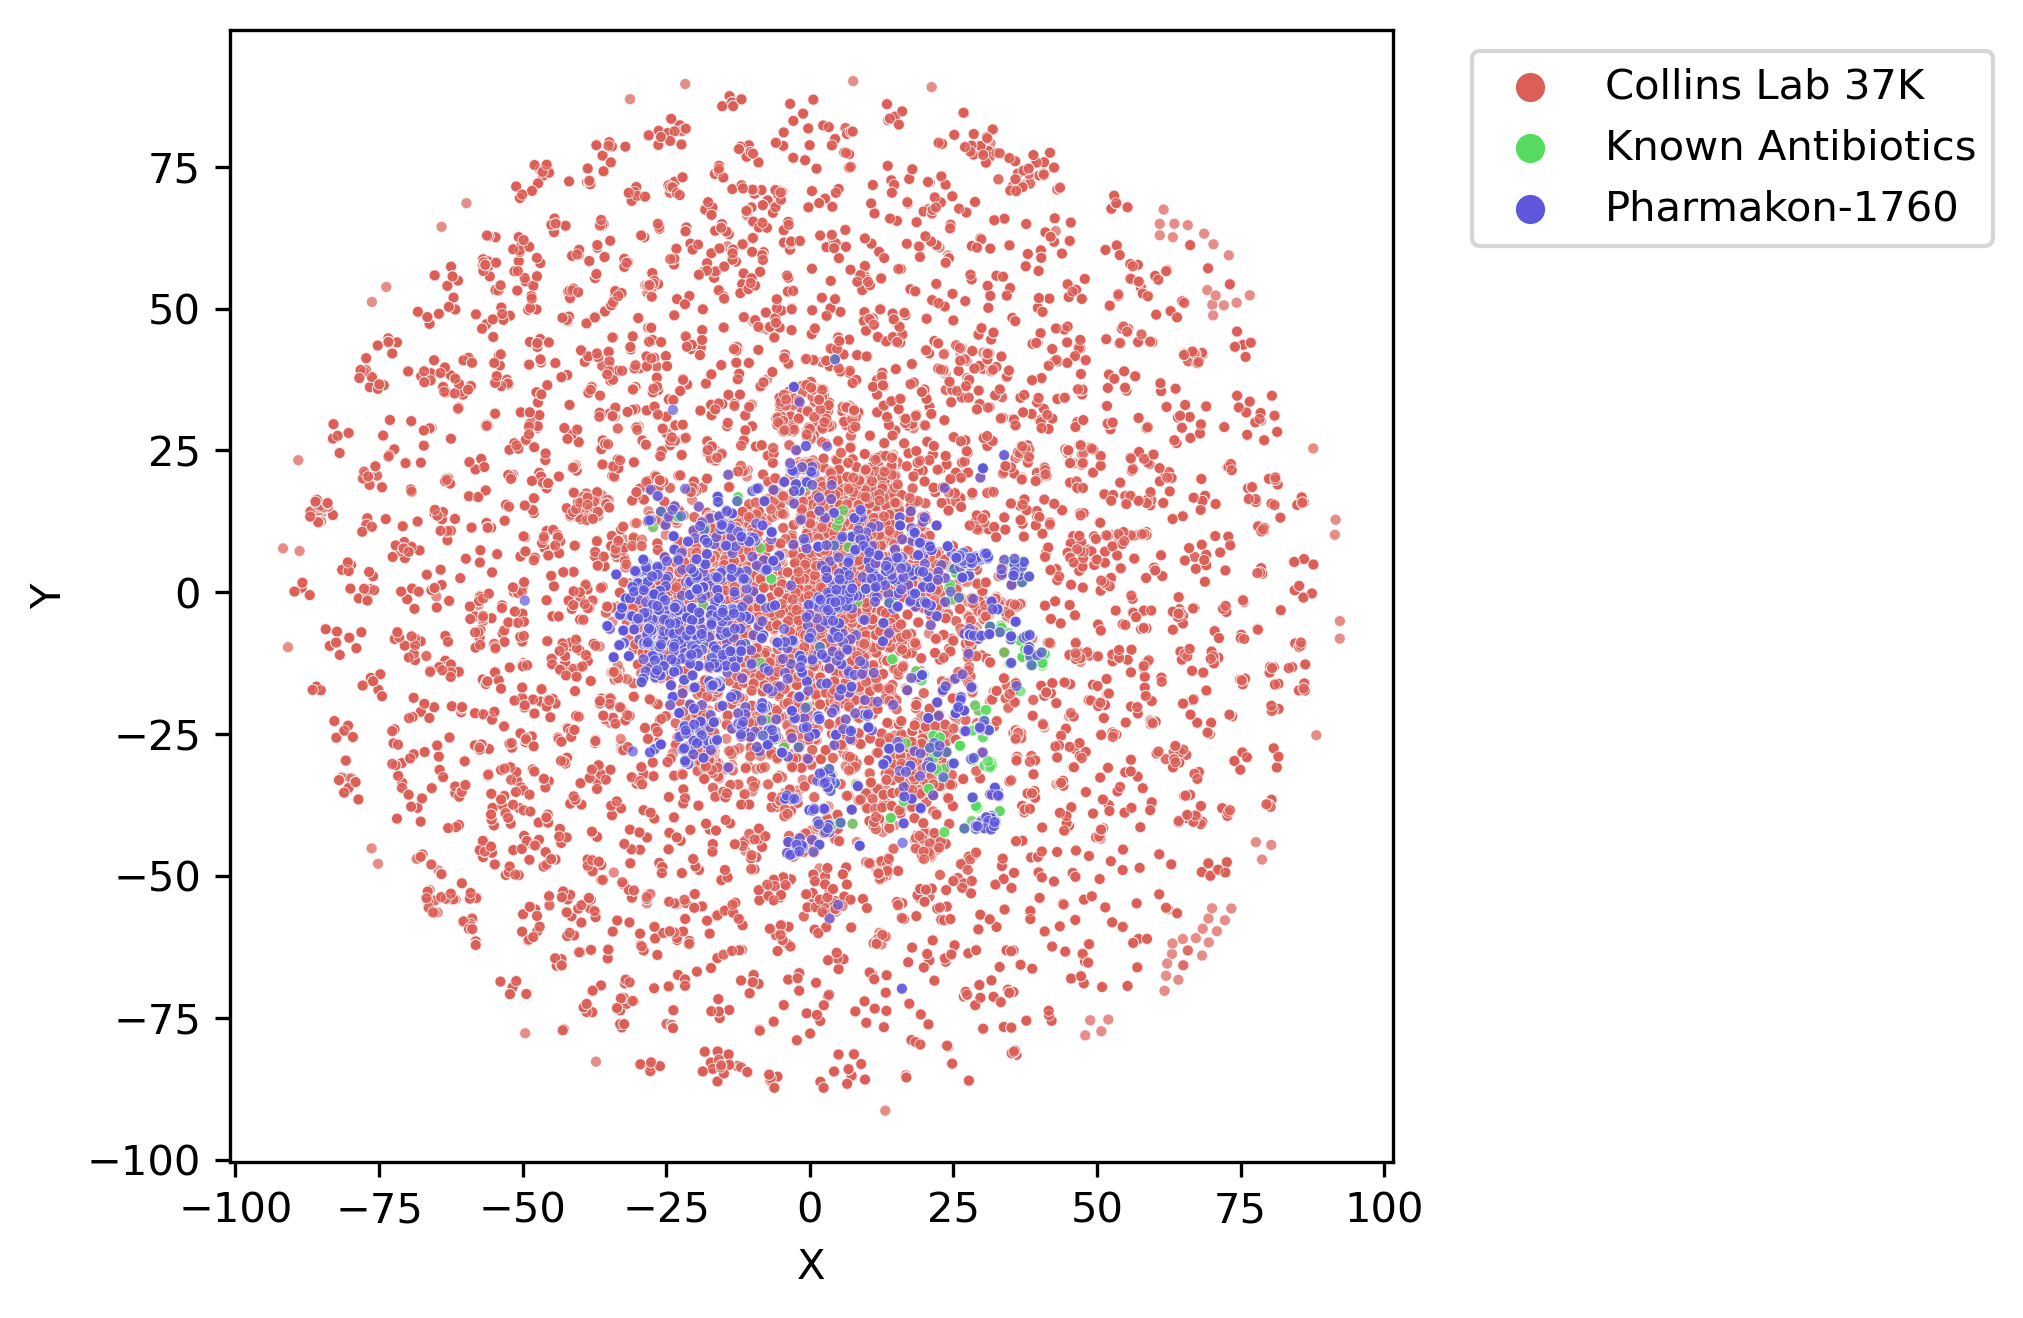

In [4]:
fp_37k = convert_df_smis_to_fps(full37konly, 'SMILES')
fp_abx = convert_df_smis_to_fps(abx, 'Smiles')
fp_pk = convert_df_smis_to_fps(pkonly, 'SMILES')

fp_list, fp_labels = make_joined_list_of_fps_and_labels([fp_37k, fp_abx, fp_pk], 
                                                       ['Collins Lab 37K', 'Known Antibiotics', 'Pharmakon-1760'])

tsne_from_pca_components(fp_list, fp_labels, '../figure_panels/tsne_37k_PK_abx')

# Plot 37K+PK hits and non-hits, abx t-SNE

/Users/jackie16201/opt/anaconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/jackie16201/opt/anaconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


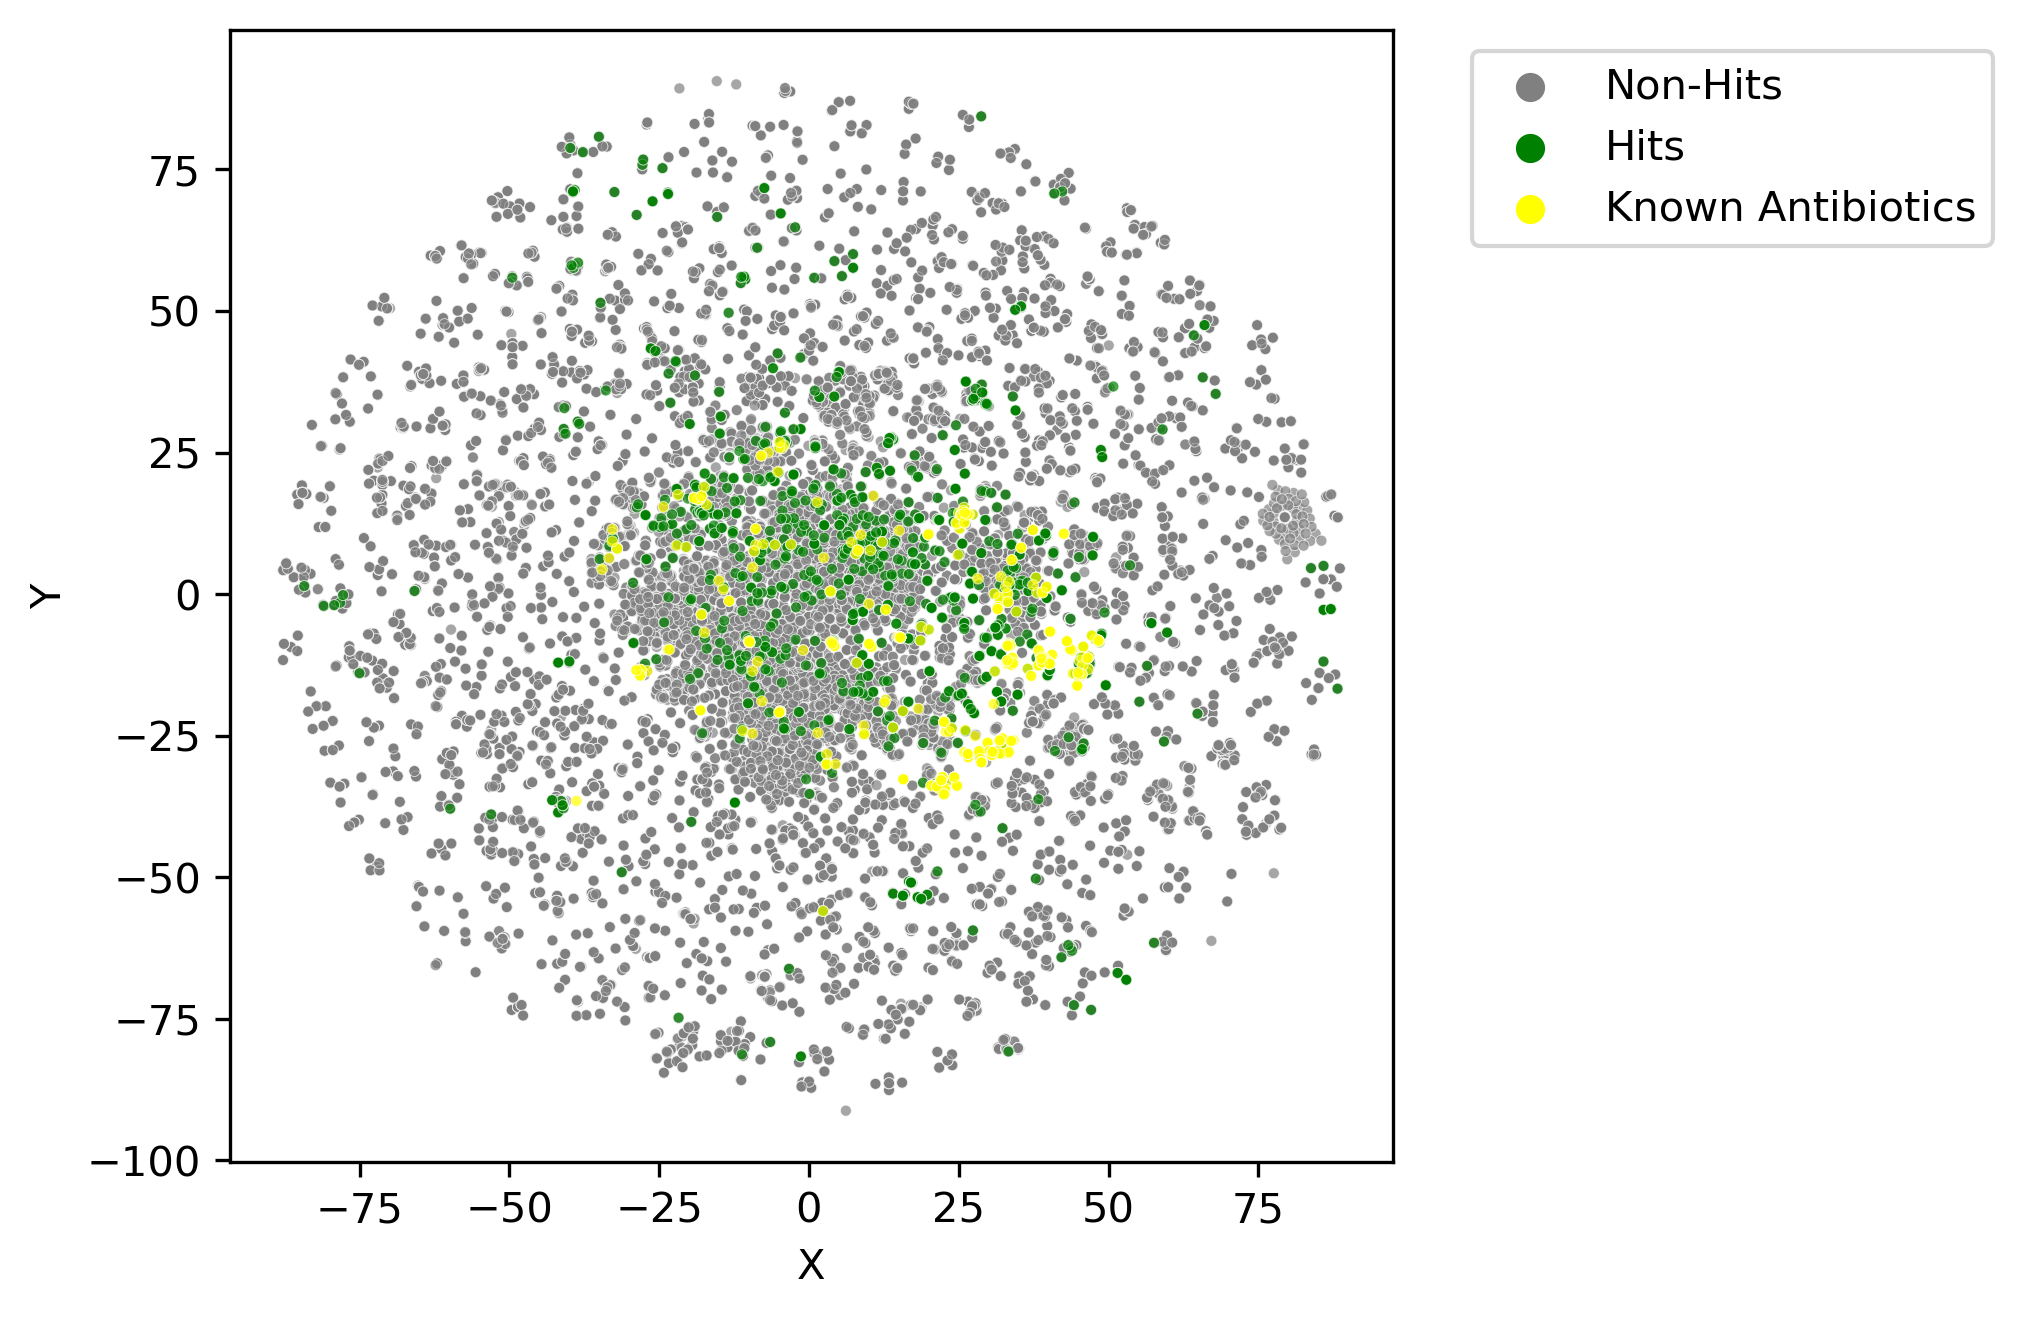

In [5]:
full37kpkhits = full37kpk[full37kpk['hit'] == 1.0]
full37kpknonhits = full37kpk[full37kpk['hit'] == 0.0]

fp_37kpkhits = convert_df_smis_to_fps(full37kpkhits)
fp_37kpknonhits = convert_df_smis_to_fps(full37kpknonhits)

fp_list, fp_labels = make_joined_list_of_fps_and_labels([fp_37kpknonhits, fp_37kpkhits, fp_abx], 
                                                       ['Non-Hits', 'Hits', 'Known Antibiotics'])

tsne_from_pca_components(fp_list, fp_labels, '../figure_panels/tsne_hits_nonhits_abx', colors = ['grey', 'green', 'yellow'])